# Processing ERA5 data in Zarr Format

This notebook demonstrates how to work with the ECMWF ERA5 reanalysis available as part of the AWS Public Dataset Program (https://registry.opendata.aws/ecmwf-era5/).

This notebook utilizes Amazon SageMaker & AWS Fargate for providing an environment with a Jupyter notebook and Dask cluster. There is an example AWS CloudFormation template available at https://github.com/awslabs/amazon-asdi/tree/main/examples/dask for quickly creating this environment in your own AWS account to run this notebook.

## Python Imports

In [2]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import s3fs
import fsspec
import dask
from dask.distributed import performance_report
from dask.distributed import Client

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

## Scale out Dask Workers

In [3]:
ecs = boto3.client('ecs')
resp = ecs.list_clusters()
clusters = resp['clusterArns']
if len(clusters) > 1:
    print("Please manually select your cluster")
cluster = clusters[0]
cluster

'arn:aws:ecs:us-east-1:816257832715:cluster/dask2-Fargate-Dask-Cluster'

In [5]:
# Scale up the Fargate cluster
numWorkers=80
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])

# Set up the Dask Client to talk to our Fargate Dask Distributed Cluster

In [6]:
client = Client('Dask-Scheduler.local-dask:8786')
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 80 Cores: 80 Memory: 560.00 GB


## Open 2-m air temperature for 10 years as a single dataset

In [7]:
def fix_accum_var_dims(ds, var):
    # Some varibles like precip have extra time bounds varibles, we drop them here to allow merging with other variables
    
    # Select variable of interest (drops dims that are not linked to current variable)
    ds = ds[[var]]  

    if var in ['air_temperature_at_2_metres',
               'dew_point_temperature_at_2_metres',
               'air_pressure_at_mean_sea_level',
               'northward_wind_at_10_metres',
               'eastward_wind_at_10_metres']:
        
        ds = ds.rename({'time0':'valid_time_end_utc'})
        
    elif var in ['precipitation_amount_1hour_Accumulation',
                 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation']:
        
        ds = ds.rename({'time1':'valid_time_end_utc'})
        
    else:
        print("Warning, Haven't seen {var} varible yet! Time renaming might not work.".format(var=var))
        
    return ds

@dask.delayed
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 20})
    return s3fs.S3Map(path, s3=fs)


def open_era5_range(start_year, end_year, variables):
    ''' Opens ERA5 monthly Zarr files in S3, given a start and end year (all months loaded) and a list of variables'''
    
    
    file_pattern = 'era5-pds/zarr/{year}/{month}/data/{var}.zarr/'
    
    years = list(np.arange(start_year, end_year+1, 1))
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    
    l = []
    for var in variables:
        print(var)
        
        # Get files
        files_mapper = [s3open(file_pattern.format(year=year, month=month, var=var)) for year in years for month in months]
        
        # Look up correct time dimension by variable name
        if var in ['precipitation_amount_1hour_Accumulation']:
            concat_dim='time1'
        else:
            concat_dim='time0'
            
        # Lazy load
        ds = xr.open_mfdataset(files_mapper, engine='zarr', 
                               concat_dim=concat_dim, combine='nested', 
                               coords='minimal', compat='override', parallel=True)
        
        # Fix dimension names
        ds = fix_accum_var_dims(ds, var)
        l.append(ds)
        
    ds_out = xr.merge(l)
    
    return ds_out

In [8]:
%%time

ds = open_era5_range(2000, 2020, ["air_temperature_at_2_metres"])

air_temperature_at_2_metres
CPU times: user 4.95 s, sys: 291 ms, total: 5.24 s
Wall time: 34.3 s


In [9]:
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 764.58



<bound method Dataset.info of <xarray.Dataset>
Dimensions:                      (lat: 721, lon: 1440, valid_time_end_utc: 184104)
Coordinates:
  * lat                          (lat) float32 90.0 89.75 89.5 ... -89.75 -90.0
  * lon                          (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * valid_time_end_utc           (valid_time_end_utc) datetime64[ns] 2000-01-...
Data variables:
    air_temperature_at_2_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>>

The `ds.info` output above shows us that there are four dimensions to the data: lat, lon, and time0; and two data variables: air_temperature_at_2_metres, and air_pressure_at_mean_sea_level.

## Convert units to F from K

In [10]:
ds['air_temperature_at_2_metres'] = (ds.air_temperature_at_2_metres - 273.15) * 9.0 / 5.0 + 32.0
ds.air_temperature_at_2_metres.attrs['units'] = 'F'

## Calculate the mean 2-m air temperature for all times

In [11]:
# calculates the mean along the time dimension
temp_mean = ds['air_temperature_at_2_metres'].mean(dim='valid_time_end_utc')

The expressions above didn’t actually compute anything. They just build the dask task graph. To do the computations, we call the `compute` method:

In [12]:
%%time

with performance_report(filename="dask-report.html"):
    temp_mean = temp_mean.compute()

CPU times: user 9.34 s, sys: 507 ms, total: 9.84 s
Wall time: 2min 17s


### Plot Average Surface Temperature

Text(0.5, 1.0, '2000-2020 Mean 2-m Air Temperature')

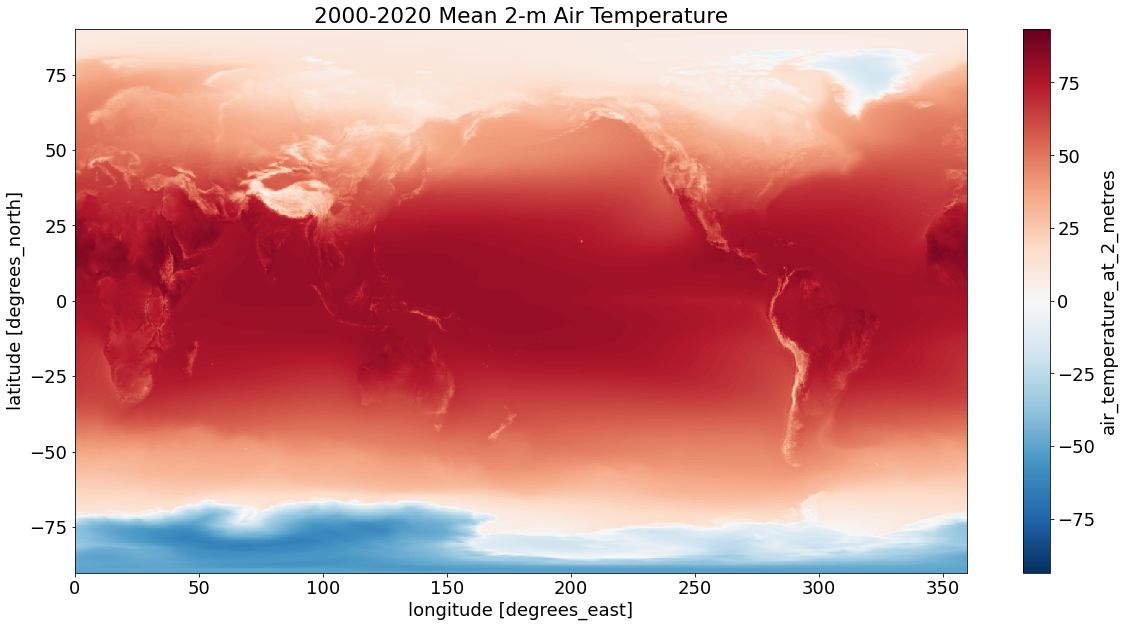

In [17]:
temp_mean.plot(figsize=(20, 10))
plt.title('2000-2020 Mean 2-m Air Temperature')

### Repeat for standard deviation

In [14]:
temp_std = ds['air_temperature_at_2_metres'].std(dim='valid_time_end_utc')

In [15]:
%time temp_std = temp_std.compute()

CPU times: user 9.21 s, sys: 278 ms, total: 9.49 s
Wall time: 2min 30s


Text(0.5, 1.0, '2000-2020 Standard Deviation 2-m Air Temperature')

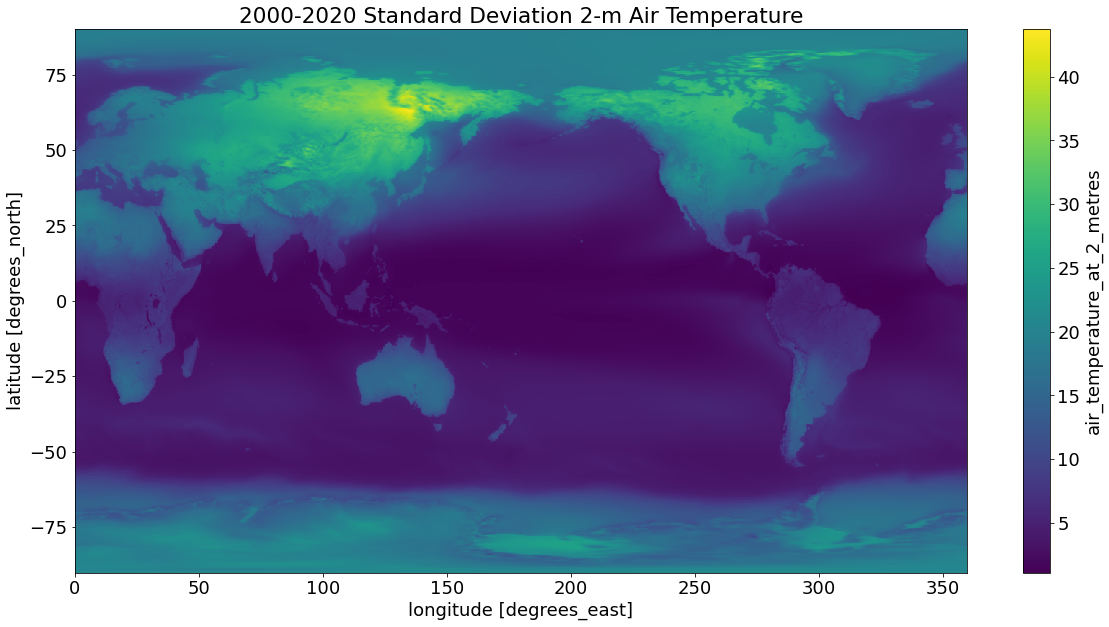

In [23]:
temp_std.plot(figsize=(20, 10))
plt.title('2000-2020 Standard Deviation 2-m Air Temperature')

## Plot temperature time series for points

In [18]:
# location coordinates
locs = [
    {'name': 'Santa Barbara', 'lon': -119.70, 'lat': 34.42},
    {'name': 'Colorado Springs', 'lon': -104.82, 'lat': 38.83},
    {'name': 'Honolulu', 'lon': -157.84, 'lat': 21.29},
    {'name': 'Seattle', 'lon': -122.33, 'lat': 47.61},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'Santa Barbara', 'lon': 240.3, 'lat': 34.42},
 {'name': 'Colorado Springs', 'lon': 255.18, 'lat': 38.83},
 {'name': 'Honolulu', 'lon': 202.16, 'lat': 21.29},
 {'name': 'Seattle', 'lon': 237.67000000000002, 'lat': 47.61}]

In [19]:
ds_locs = xr.Dataset()
air_temp_ds = ds

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = air_temp_ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
    ds2 = ds2.rename({'air_temperature_at_2_metres' : var_name}).drop(('lat', 'lon'))

    ds_locs = xr.merge([ds_locs, ds2])

ds_locs.data_vars

Data variables:
    Santa Barbara     (valid_time_end_utc) float32 dask.array<chunksize=(372,), meta=np.ndarray>
    Colorado Springs  (valid_time_end_utc) float32 dask.array<chunksize=(372,), meta=np.ndarray>
    Honolulu          (valid_time_end_utc) float32 dask.array<chunksize=(372,), meta=np.ndarray>
    Seattle           (valid_time_end_utc) float32 dask.array<chunksize=(372,), meta=np.ndarray>

### Convert to dataframe

In [20]:
df_f = ds_locs.to_dataframe()
df_f.describe()

,Santa Barbara,Colorado Springs,Honolulu,Seattle
count,184104.000000,184104.000000,184104.000000,184104.000000
mean,60.488968,47.018040,75.470932,52.459888
std,9.790099,19.985313,2.520102,10.928419
min,32.067513,-25.982491,62.667511,14.067511
25%,52.992512,31.476269,73.692513,44.330009
50%,60.417511,47.030010,75.605011,51.530010
75%,67.617508,61.767509,77.292511,59.967510
max,96.867508,98.330009,83.817513,98.330009


## Plot January temperatures

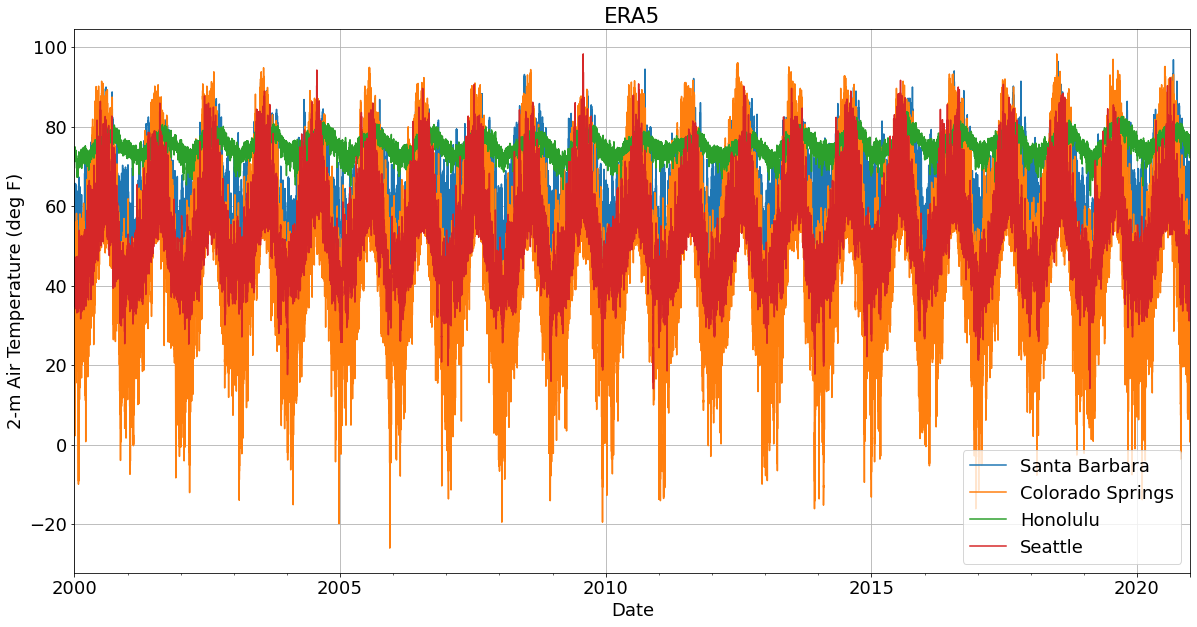

In [21]:
ax = df_f.plot(figsize=(20, 10), title="ERA5", grid=1)
ax.set(xlabel='Date', ylabel='2-m Air Temperature (deg F)')
plt.show()

## Cluster scale down

When we are temporarily done with the cluster we can scale it down to save on costs

In [22]:
numWorkers=0
ecs.update_service(cluster=cluster, service='Dask-Worker', desiredCount=numWorkers)
ecs.get_waiter('services_stable').wait(cluster=cluster, services=['Dask-Worker'])